In [1]:
from threeML import *

from HAWCpyLike import HAWCpyLike
import region_of_interest

import os

os.environ['OMP_NUM_THREADS'] = "1"

%matplotlib notebook

Configuration read from /home/giacomov/.threeML/threeML_config.yml
Plotter is MatPlotlib


In [2]:
ra_crab, dec_crab = 83.633083, 22.014500

roi = region_of_interest.HealpixConeROI(5.0, ra=ra_crab, dec=dec_crab)

hawc = HAWCpyLike("HAWC", 
                  "/home/giacomov/science/hawc/data/maptree_1024.root", 
                  "/home/giacomov/science/hawc/data/response.root",
                  roi)

hawc.set_active_measurements(1, 9)

hawc.display()

Creating singleton for /home/giacomov/science/hawc/data/response.root
Response: 
----------

Response file: /home/giacomov/science/hawc/data/response.root
Number of dec bins: 106
Number of energy/nHit planes per dec bin_name: 10

Map Tree: 
----------



,Bin,Nside,Scheme,Obs counts,Bkg counts,obs/bkg,Pixels in ROI,Area (deg^2)
0,0,1024,RING,2.359288e+09,2.358957e+09,1.000141,23947,78.510019
1,1,1024,RING,1.563526e+08,1.562712e+08,1.000521,23947,78.510019
2,2,1024,RING,5.008916e+07,5.004267e+07,1.000929,23947,78.510019
3,3,1024,RING,1.370908e+07,1.367816e+07,1.002261,23947,78.510019
4,4,1024,RING,1.748741e+06,1.737266e+06,1.006605,23947,78.510019
5,5,1024,RING,3.882100e+05,3.829631e+05,1.013701,23947,78.510019
6,6,1024,RING,7.008800e+04,6.834725e+04,1.025469,23947,78.510019
7,7,1024,RING,4.146500e+04,4.048585e+04,1.024185,23947,78.510019
8,8,1024,RING,1.119500e+04,1.084205e+04,1.032553,23947,78.510019
9,9,1024,RING,1.546200e+04,1.503629e+04,1.028312,23947,78.510019


This Map Tree contains 911.282 transits
Total data size: 1.92 Mb

Active energy/nHit planes: 
---------------------------

[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [3]:
spectrum = Log_parabola()

source = PointSource("CrabNebula", ra=ra_crab, dec=dec_crab, spectral_shape=spectrum)

# NOTE: if you use units, you have to set up the values for the parameters
# AFTER you create the source, because during creation the function Log_parabola
# gets its units

source.position.ra.bounds = (ra_crab - 0.5, ra_crab + 0.5)
source.position.dec.bounds = (dec_crab - 0.5, dec_crab + 0.5)

spectrum.piv = 10 * u.TeV  # Pivot energy
spectrum.piv.fix = True

spectrum.K = 1e-14 / (u.TeV * u.cm**2 * u.s)  # norm (in 1/(keV cm2 s))
spectrum.K.bounds = (1e-25, 1e-19) # without units energies are in keV

spectrum.beta = 0  # log parabolic beta
spectrum.beta.bounds = (-4., 2.)

spectrum.alpha = -2.5  # log parabolic alpha (index)
spectrum.alpha.bounds = (-4., 2.)

model = Model(source)

data = DataList(hawc)

In [4]:
%load_ext line_profiler

from partial_image_to_healpix import FlatSkyToHealpixTransform

In [5]:
jl = JointLikelihood(model, data, verbose=False)
jl.set_minimizer("minuit")
#%lprun -f FlatSkyToHealpixTransform.__call__ 
#%lprun -f hawc.get_log_like _ = jl.fit(quiet=False)

%prun _ = jl.fit(quiet=False)

# 12 s

# CrabNebula.spectrum.main.Log_parabola.K	(9.910 +/- 0.17) x 10^-23	1 / (cm2 keV s)
# CrabNebula.spectrum.main.Log_parabola.alpha	-2.793 +/- 0.018	
# CrabNebula.spectrum.main.Log_parabola.beta	(1.550 +/- 0.11) x 10^-1

Best fit values:



,result,unit
parameter,,
CrabNebula.spectrum.main.Log_parabola.K,(9.910 +/- 0.17) x 10^-23,1 / (cm2 keV s)
CrabNebula.spectrum.main.Log_parabola.alpha,-2.793 +/- 0.018,
CrabNebula.spectrum.main.Log_parabola.beta,(1.550 +/- 0.11) x 10^-1,



Correlation matrix:



1.00,-0.05,0.64
-0.05,1.00,-0.71
0.64,-0.71,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
HAWC,658297.484354
total,658297.484354



Values of statistical measures:



,statistical measures
AIC,1.316601e+06
BIC,1.316632e+06


In [6]:
source.position.ra.free = True
source.position.dec.free = True

jl.set_minimizer("ROOT")

best_fit, like_frame = jl.fit()

# CrabNebula.position.ra	(8.362 +/- 0.00026) x 10	deg
# CrabNebula.position.dec	(2.202 +/- 0.00024) x 10	deg
# CrabNebula.spectrum.main.Log_parabola.K	(9.970 +/- 0.17) x 10^-23	1 / (cm2 keV s)
# CrabNebula.spectrum.main.Log_parabola.alpha	-2.798 +/- 0.021	
# CrabNebula.spectrum.main.Log_parabola.beta	(1.590 +/- 0.13) x 10^-1

Best fit values:



,result,unit
parameter,,
CrabNebula.position.ra,(8.362 +/- 0.00025) x 10,deg
CrabNebula.position.dec,(2.202 +/- 0.00024) x 10,deg
CrabNebula.spectrum.main.Log_parabola.K,(9.920 +/- 0.17) x 10^-23,1 / (cm2 keV s)
CrabNebula.spectrum.main.Log_parabola.alpha,-2.793 +/- 0.018,
CrabNebula.spectrum.main.Log_parabola.beta,(1.550 +/- 0.11) x 10^-1,



Correlation matrix:



1.00,0.07,-0.01,0.00,-0.01
0.07,1.00,-0.00,0.01,-0.00
-0.01,-0.00,1.00,-0.05,0.64
0.00,0.01,-0.05,1.00,-0.71
-0.01,-0.00,0.64,-0.71,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
HAWC,658279.010176
total,658279.010176



Values of statistical measures:



,statistical measures
AIC,1.316568e+06
BIC,1.316620e+06


In [7]:
best_fit

,value,negative_error,positive_error,error,unit
CrabNebula.position.ra,8.361966e+01,-2.464758e-03,2.465270e-03,2.465014e-03,deg
CrabNebula.position.dec,2.202079e+01,-2.346841e-03,2.471308e-03,2.409074e-03,deg
CrabNebula.spectrum.main.Log_parabola.K,9.920773e-23,-1.601700e-24,1.675926e-24,1.638813e-24,1 / (cm2 keV s)
CrabNebula.spectrum.main.Log_parabola.alpha,-2.792585e+00,-1.807348e-02,1.805751e-02,1.806550e-02,
CrabNebula.spectrum.main.Log_parabola.beta,1.552660e-01,-1.013792e-02,1.085910e-02,1.049851e-02,


In [8]:
from astromodels.utils.angular_distance import angular_distance

angular_distance(ra_crab, dec_crab,  best_fit['value']['CrabNebula.position.ra'], 
                 best_fit['value']['CrabNebula.position.dec'])

0.013939456613864212

In [9]:
_ = jl.get_errors()

# CrabNebula.position.ra	(8.36201 -0.00027 +0.00026) x 10	deg
# CrabNebula.position.dec	(2.20206 -0.00025 +0.00023) x 10	deg
# CrabNebula.spectrum.main.Log_parabola.K	(1.010 +/- 0.017) x 10^-22	1 / (cm2 keV s)
# CrabNebula.spectrum.main.Log_parabola.alpha	-2.797 +/- 0.019	
# CrabNebula.spectrum.main.Log_parabola.beta	(1.630 +/- 0.11) x 10^-1

,result,unit
parameter,,
CrabNebula.position.ra,(8.36197 -0.00026 +0.00025) x 10,deg
CrabNebula.position.dec,(2.202 +/- 0.00024) x 10,deg
CrabNebula.spectrum.main.Log_parabola.K,(9.92 -0.17 +0.18) x 10^-23,1 / (cm2 keV s)
CrabNebula.spectrum.main.Log_parabola.alpha,-2.793 -0.018 +0.020,
CrabNebula.spectrum.main.Log_parabola.beta,(1.55 -0.12 +0.13) x 10^-1,


<IPython.core.display.Javascript object>


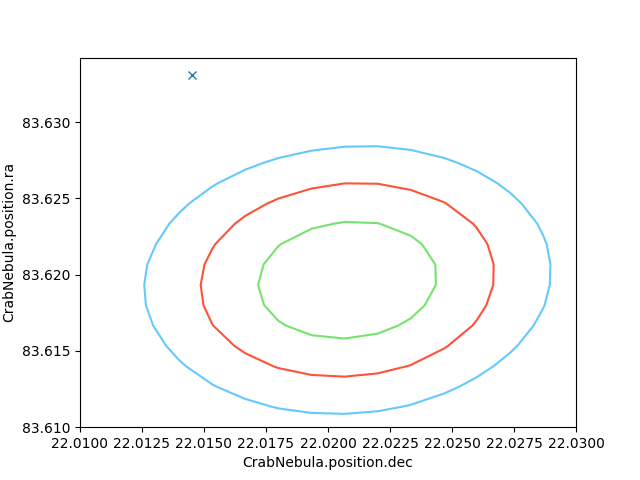

In [8]:
_ = jl.get_contours(model.CrabNebula.position.ra, 83.610, 83.630, 16, 
                    model.CrabNebula.position.dec, 22.010, 22.030, 16)

import matplotlib.pyplot as plt

plt.plot([dec_crab], [ra_crab], 'x')

# Parallel: 183.5

# 225 / 225 in 249.2 s (0:00:00 remaining)

In [15]:
print spectrum(1.0 * u.TeV).to(1/(u.TeV * u.cm**2 * u.s))

2.70253017991e-11 1 / (cm2 s TeV)
